# Dieses Notebook zeigt ein LSTM-basiertes Nachfrageprognose-Experiment für die Region Guayas. Die Modellierung erfolgt auf aggregierten Tagesverkäufen pro Produktfamilie und dient dem Vergleich mit einem XGBoost-Baseline-Modell.

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [ ]:
from sklearn.metrics.pairwise import np
from IPython.core.debugger import Pdb
from IPython.core.interactiveshell import no_op
# Mini-LSTM Code

import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

print("TensorFlow:", tf.__version__)

# Datei laden..
df = pd.read_pickle("guayas_top3_sample.pkl")
df["date"] = pd.to_datetime(df["date"])

# Zeitraum Q1 2014
df = df[(df["date"] >= "2014-01-01") & (df["date"] < "2014-04-01")].copy()

# Aggregation: tägliche Verkäufe pro Family
daily = df.groupby(["date", "family"], as_index=False)["unit_sales"].sum()

all_days = pd.date_range("2014-01-01", "2014-03-31", freq="D")
families = sorted(daily["family"].unique())

def make_sequences(y, window=14):
  X, t = [], []
  for i in range(window, len(y)):
    X.append(y[i-window:i])
    t.append(y[i])
  X = np.array(X, dtype=np.float32)[..., None]  #(samples, window, 1)
  t = np.array(t, dtype=np.float32)
  return X, t # Changed tf to t

WINDOW = 14
split_date = pd.Timestamp("2014-03-01") # Changed year to 2014

results =[]

for fam in families:
  s = (daily[daily["family"]==fam]
       .set_index("date")
       .reindex(all_days))

#fehlende Tage = 0 (dichte Zeitreihe)
s["unit_sales"] = s["unit_sales"].fillna(0.0)

y = s["unit_sales"].values.astype(np.float32)

# Train: Jan+Feb, Test: März
split_idx = np.searchsorted(all_days.values, np.datetime64(split_date)) # Changed np.serchsorted to np.searchsorted

X_all, y_all = make_sequences(y, WINDOW)
seq_split = max(0, split_idx - WINDOW)

X_train, y_train = X_all[:seq_split], y_all[:seq_split]
X_test, y_test = X_all[seq_split:], y_all[seq_split:] # Changed seq_spilt to seq_split

# --- LSTM Modell (mini)
model = models.Sequential([
    layers.Input(shape=(WINDOW,1)),
    layers.LSTM(32),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)
])
model.compile(optimizer="adam", loss="mse")

model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

y_pred = model.predict(X_test, verbose=0).reshape(-1)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

results.append((fam, mae, rmse))
print(f"\nFamilie: {fam}")
print("MAE :", mae)
print("RMSE:", rmse)

print("\n--- Zusammenfassung ---")
for fam, mae, rmse in results:
    print(f"{fam:10s} | MAE={mae:.3f} | RMSE={rmse:.3f}")

TensorFlow: 2.19.0

Familie: GROCERY I
MAE : 340.3427734375
RMSE: 360.0180117021925

--- Zusammenfassung ---
GROCERY I  | MAE=340.343 | RMSE=360.018


Warum ist MAE / RMSE so hoch?
👉 alle Stores in Guayas
👉 alle Items der Familie
👉 pro Tag aufsummiert

Für GROCERY I bedeutet das:

hunderte Artikel

mehrere Stores

Tagesumsätze im Bereich von mehreren Tausend Einheiten

➡️ Ein MAE von ~340 heißt:

Das Modell liegt im Schnitt um ca. 340 verkaufte Einheiten pro Tag daneben

Das ist absolut realistisch für diese Aggregation.

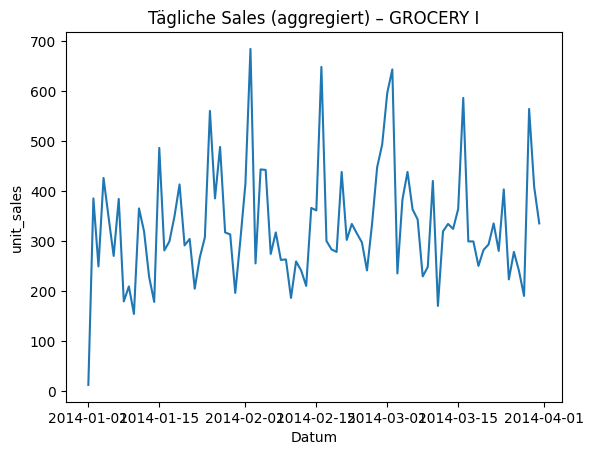

In [ ]:
import matplotlib.pyplot as plt

# Beispiel: erste Familie plotten
fam = results[0][0]
s = (daily[daily["family"]==fam].set_index("date").reindex(all_days))
s["unit_sales"] = s["unit_sales"].fillna(0.0).values

plt.figure()
plt.plot(all_days, s["unit_sales"].values)
plt.title(f"Tägliche Sales (aggregiert) – {fam}")
plt.xlabel("Datum")
plt.ylabel("unit_sales")
plt.show()


Das **XGBoost-Modell** wurde auf Store-Item-Ebene mit Lag- und Kalender-Features trainiert und erzielte vergleichsweise niedrige Fehlerwerte. Es profitierte stark von strukturierten Merkmalen wie Wochentag und vorherigen Verkaufswerten. Das **LSTM-Modell** hingegen wurde auf aggregierter Ebene (tägliche Verkäufe pro Produktfamilie) trainiert und zeigte deutlich höhere Fehlermaße. Diese sind jedoch durch die größere Skala der Zielvariable erklärbar. Insgesamt erwies sich XGBoost für diese Daten und den kurzen Zeitraum als robuster und besser geeignet, während das LSTM-Modell eher explorativen Charakter hatte.